Import packages and navigate to model data directory

In [1]:
# Import packages
import os
import emc2
import xarray as xr
import pandas as pd
import numpy as np
from emc2.core import Instrument
from emc2.core.instrument import ureg
from emc2.core import Model
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from datetime import datetime, timedelta
import netCDF4 as nc
from emc2.core.instruments import HSRL
from emc2.core.instruments import WACR

# Navigate to the UM_reg data directory
os.chdir('/g/data3/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2')
# Check current project directory
print("Project directory:", os.getcwd())

Project directory: /g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2


Create the UM regional model class

In [7]:
class UM(Model):
    def __init__(self, file_path):
        """
        This loads a UM simulation with all of the necessary parameters for EMC2 to run.
        Parameters
        ----------
        file_path: str
        Path to a UM simulation.
        """
        super().__init__()
        self.Rho_hyd = {'cl': 1000. * ureg.kg / (ureg.m**3),
                        'ci': 500. * ureg.kg / (ureg.m**3),
                        'pl': 1000. * ureg.kg / (ureg.m**3),
                        'pi': 250. * ureg.kg / (ureg.m**3),
                        'gr': 500. * ureg.kg / (ureg.m**3)}
        # Graupel densities can range from 0.2 to about 0.8 gcm^−3, so I'm choosing 0.5 gcm^-3, or 500 kgm^-3
        self.fluffy = {'ci': 0.5 * ureg.dimensionless,
                       'pi': 0.5 * ureg.dimensionless,
                       'gr': 0.5 * ureg.dimensionless}
        # Possible fluffiness parameter apparently from Field et al. (2023), Table A1, is 0.422; however, for now I will leave this the same as for the other ice species
        self.lidar_ratio = {'cl': 18. * ureg.dimensionless,
                            'ci': 24. * ureg.dimensionless,
                            'pl': 5.5 * ureg.dimensionless,
                            'pi': 24. * ureg.dimensionless,
                            'gr': 24. * ureg.dimensionless}
        # Graupel lidar ratio assumed to be the same as for other ice species
        self.LDR_per_hyd = {'cl': 0.03 * 1 / (ureg.kg / (ureg.m**3)),
                            'ci': 0.35 * 1 / (ureg.kg / (ureg.m**3)),
                            'pl': 0.10 * 1 / (ureg.kg / (ureg.m**3)),
                            'pi': 0.40 * 1 / (ureg.kg / (ureg.m**3)),
                            'gr': 0.013 * 1 / (ureg.kg / (ureg.m**3))}
        # From Oue et al. (2015) Figures 3 & 4, the identified graupel cases (A and C) show linear depolarization ratios between -20 and -18 dB, which translates to an LDR of 0.013, which seems much too low
        self.vel_param_a = {'cl': 3e-7,
                            'ci': 700.,
                            'pl': 841.997,
                            'pi': 11.72,
                            'gr': 253.}
        # Fall velocity parameter a from Field et al. (2023), Table A1
        self.vel_param_b = {'cl': 2. * ureg.dimensionless,
                            'ci': 1. * ureg.dimensionless,
                            'pl': 0.8 * ureg.dimensionless,
                            'pi': 0.41 * ureg.dimensionless,
                            'gr': 0.734 * ureg.dimensionless}
        # Fall velocity parameter b from Field et al. (2023), Table A1
        super()._add_vel_units()
        # Names of mixing ratio of species
        self.q_names = {'cl': 'field254', 'ci': 'field271', 'pl': 'field272', 'pi': 'field12', 'gr': 'field273'}
        # Number concentration of each species
        self.N_field = {'cl': 'field75', 'ci': 'field78', 'pl': 'field76', 'pi': 'field79', 'gr': 'field81'}
        # Stratiform fraction
        self.strat_frac_names = {'cl': 'field267', 'ci': 'field268', 'pl': 'zeros_var', 'pi': 'zeros_var', 'gr': 'zeros_var'}
        self.strat_frac_names_for_rad = {'cl': 'field267', 'ci': 'field268', 'pl': 'zeros_var', 'pi': 'zeros_var', 'gr': 'zeros_var'}
        # Convective fraction
        self.conv_frac_names = {'cl': 'zeros_var', 'ci': 'zeros_var', 'pl': 'zeros_var', 'pi': 'zeros_var', 'gr': 'zeros_var'}
        self.conv_frac_names_for_rad = {'cl': 'zeros_var', 'ci': 'zeros_var', 'pl': 'zeros_var', 'pi': 'zeros_var', 'gr': 'zeros_var'}
        # Effective radius
        self.re_fields = {'cl': 're_mccl', 'ci': 're_mcci', 'pl': 're_mcpl', 'pi': 're_mcpi', 'gr': 're_mcpg'}
        self.strat_re_fields = {'cl': 're_mccl', 'ci': 're_mcci', 'pl': 're_mcpl', 'pi': 're_mcpi', 'gr': 're_mcpg'}
        self.conv_re_fields = {'cl': 'zeros_var', 'ci': 'zeros_var', 'pl': 'zeros_var', 'pi': 'zeros_var', 'gr': 'zeros_var'}
        # Stratiform mixing ratio
        self.q_names_stratiform = {'cl': 'field254', 'ci': 'field271', 'pl': 'field272', 'pi': 'field12', 'gr': 'field273'}
        # Convective mixing ratio
        self.q_names_convective = {'cl': 'zeros_var', 'ci': 'zeros_var', 'pl': 'zeros_var', 'pi': 'zeros_var', 'gr': 'zeros_var'}
        # Water vapor mixing ratio
        self.q_field = "hus"
        # Pressure
        self.p_field = "field408"
        # Height
        self.z_field = "z"
        # Temperature
        self.T_field = "ta"
        # Name of height dimension
        self.height_dim = "z0_hybrid_height"
        # Name of time dimension
        self.time_dim = "time"
        self.hyd_types = ["cl", "ci", "pl", "pi", "gr"]
        self.process_conv = False
        self.model_name = "UM_reg"
        self.ds = xr.open_dataset(file_path)

Create the MPL instrument class instance

In [8]:
MPL = HSRL()

Create the MWACR instrument class instance

In [9]:
MWACR = WACR(site = 'micre')

Create the UM_reg model class instance for each day and create the simulated data

In [14]:
# Create the list of full filepaths to the daily files

# Set daily file parent folder
daily_filepath = '/g/data/jk72/ck4840/projects/emc2/data/um_reg/'
# List daily files in the parent folder
daily_UM_reg_list = os.listdir(path = daily_filepath)
# Create the list of daily filepaths
daily_UM_reg_list = [os.path.join(daily_filepath, file) for file in daily_UM_reg_list]
# Sort the list by date
def extract_date(filepath):
    return filepath[12:-3]
daily_UM_reg_list = sorted(daily_UM_reg_list, key = extract_date)
daily_UM_reg_list = [path for path in daily_UM_reg_list if 'um_reg_marcus_' in path]
daily_UM_reg_list

['/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180201.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180202.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180203.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180204.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180205.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180206.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180207.nc']

In [15]:
# Output path
output_folder = '/g/data/jk72/ck4840/projects/emc2/data/um_reg/emc2_output'

# SINGLE FILE TEST
# daily_UM_reg_list = [daily_UM_reg_list[0]]

# Loop across all files in daily_UM_reg_list, run the EMC2 simulator for each, and save the .ds output
for file in daily_UM_reg_list:
    
    # Get the string for the current date
    current_date_str = file.split('_')[-1].split('.')[0]

    # Create an instance of UM_reg model class
    UM_reg_instance = UM(file)

    # Create simulated data from UM_reg_instance and MPL
    UM_reg_emc2_marcus_MPL_model = emc2.simulator.main.make_simulated_data(UM_reg_instance, MPL, N_columns = 1, do_classify = True, convert_zeros_to_nan = True, use_rad_logic = False)

    # Create simulated data from UM_reg_instance and MWACR
    UM_reg_emc2_marcus_MWACR_model = emc2.simulator.main.make_simulated_data(UM_reg_instance, MWACR, N_columns = 1, do_classify = True, convert_zeros_to_nan = True, use_rad_logic = False, parallel = False)
    
    # Save the simulated .ds for MPL and MWACR
    UM_reg_emc2_marcus_MPL_model_data = UM_reg_emc2_marcus_MPL_model.ds
    UM_reg_emc2_marcus_MWACR_model_data = UM_reg_emc2_marcus_MWACR_model.ds
    file_path_output_MPL = f'{output_folder}/um_reg_emc2_marcus_MPL_{current_date_str}.nc'
    file_path_output_MWACR = f'{output_folder}/um_reg_emc2_marcus_MWACR_{current_date_str}.nc'
    UM_reg_emc2_marcus_MPL_model_data.to_netcdf(file_path_output_MPL)
    UM_reg_emc2_marcus_MWACR_model_data.to_netcdf(file_path_output_MWACR)

## Creating subcolumns...
No convective processing for UM_reg
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns frac fields to 1 for startiform cl and ci based on q > 0. kg/kg
Done! total processing time = 0.01s
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns frac fields to 1 for strat precip based on q > 0. kg/kg
Done! total processing time = 0.00s
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for cl equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for ci equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for pl equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for pi equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcol

# Single file testing

In [45]:
file = daily_UM_reg_list[4]
print(file)
UM_reg_instance = UM(file)
UM_reg_instance.ds

/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180205.nc


<xarray.Dataset>
Dimensions:           (z0_hybrid_height: 90, time: 144)
Coordinates:
  * z0_hybrid_height  (z0_hybrid_height) float64 5.0 17.14 ... 3.867e+04 4e+04
  * time              (time) datetime64[ns] 2018-02-05T00:01:00 ... 2018-02-0...
Data variables: (12/23)
    hus               (time, z0_hybrid_height) float32 ...
    field12           (time, z0_hybrid_height) float32 ...
    field75           (time, z0_hybrid_height) float32 ...
    field76           (time, z0_hybrid_height) float32 ...
    field78           (time, z0_hybrid_height) float32 ...
    field79           (time, z0_hybrid_height) float32 ...
    ...                ...
    re_mccl           (time, z0_hybrid_height) float32 ...
    re_mcci           (time, z0_hybrid_height) float32 ...
    re_mcpl           (time, z0_hybrid_height) float32 ...
    re_mcpi           (time, z0_hybrid_height) float32 ...
    zeros_var         (time, z0_hybrid_height) float64 ...
    z                 (time, z0_hybrid_height) float64 ...

Create simulated data from UM_reg_instance and MPL

In [43]:
# Create simulated MPL radar data with multiple subcolumns
UM_reg_emc2_marcus_MPL_model = emc2.simulator.main.make_simulated_data(UM_reg_instance, MPL, N_columns = 2, do_classify = True, convert_zeros_to_nan = True, use_rad_logic = False, parallel = False)

## Creating subcolumns...
No convective processing for UM_reg
Fully overcast cl & ci in 3 voxels
Done! total processing time = 0.44s
Fully overcast pl & pi in 0 voxels
Done! total processing time = 0.06s
Generating lidar moments...
Generating stratiform lidar variables using microphysics logic (slowest processing)
Generating stratiform lidar variables for hydrometeor class cl
Stratiform moment for class cl progress: 0/144
Stratiform moment for class cl progress: 50/144
Stratiform moment for class cl progress: 100/144
Generating stratiform lidar variables for hydrometeor class ci
Stratiform moment for class ci progress: 0/144
Stratiform moment for class ci progress: 50/144
Stratiform moment for class ci progress: 100/144
Generating stratiform lidar variables for hydrometeor class pl
Stratiform moment for class pl progress: 0/144
Stratiform moment for class pl progress: 50/144
Stratiform moment for class pl progress: 100/144
Generating stratiform lidar variables for hydrometeor class pi


Create simulated data from UM_reg_instance and MWACR

In [46]:
# Reset the input data
UM_reg_instance = UM(file)
# Create simulated radar data
UM_reg_emc2_marcus_MWACR_model = emc2.simulator.main.make_simulated_data(UM_reg_instance, MWACR, N_columns = 1, do_classify = True, convert_zeros_to_nan = True, use_rad_logic = False, parallel = False)

## Creating subcolumns...
No convective processing for UM_reg
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns frac fields to 1 for startiform cl and ci based on q > 0. kg/kg
Done! total processing time = 0.02s
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns frac fields to 1 for strat precip based on q > 0. kg/kg
Done! total processing time = 0.01s
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for cl equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for ci equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for pl equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for pi equal to grid-cell mean
Generating radar moments...
Generating stratiform radar variables us

In [47]:
UM_reg_emc2_marcus_MWACR_model_data = UM_reg_emc2_marcus_MWACR_model.ds
file_path_output = '/g/data/jk72/ck4840/projects/emc2/data/um_reg/emc2_output/um_reg_emc2_marcus_MWACR_test.nc'
UM_reg_emc2_marcus_MWACR_model_data.to_netcdf(file_path_output)

In [14]:
# MPL
# UM_reg_emc2_marcus_MPL_model.ds
# UM_reg_instance.ds
# These datasets appear the same - emc2.simulator.main.make_simulated_data is modifying UM_reg_instance even as it creates UM_reg_emc2_marcus_MPL_model

# MWACR
UM_reg_emc2_marcus_MWACR_model.ds

<xarray.Dataset>
Dimensions:                           (z0_hybrid_height: 90, time: 144,
                                       subcolumn: 1)
Coordinates:
  * z0_hybrid_height                  (z0_hybrid_height) float64 5.0 ... 4e+04
  * time                              (time) datetime64[ns] 2018-02-05T00:01:...
  * subcolumn                         (subcolumn) int64 0
Data variables: (12/51)
    hus                               (time, z0_hybrid_height) float32 0.0023...
    field12                           (time, z0_hybrid_height) float32 0.0 .....
    field75                           (time, z0_hybrid_height) float32 ...
    field76                           (time, z0_hybrid_height) float32 ...
    field78                           (time, z0_hybrid_height) float32 ...
    field79                           (time, z0_hybrid_height) float32 ...
    ...                                ...
    sub_col_Ze_att_tot_strat          (subcolumn, time, z0_hybrid_height) float64 ...
    Ze_min                            (time, z0_hybrid_height) float64 -82.02...
    sub_col_Ze_tot                    (subcolumn, time, z0_hybrid_height) float64 ...
    sub_col_Ze_att_tot                (subcolumn, time, z0_hybrid_height) float64 ...
    detect_mask                       (time, z0_hybrid_height, subcolumn) bool ...
    phase_mask_WACR_sounding_all_hyd  (subcolumn, time, z0_hybrid_height) float64 ...

In [21]:
Dims = UM_reg_emc2_marcus_MWACR_model.ds["strat_q_subcolumns_cl"].values.shape
print(Dims)
print(type(Dims))

(1, 144, 90)
<class 'tuple'>


In [26]:
def _calculate_other_observables(tt, total_hydrometeor, N_0, lambdas,
                                 num_subcolumns, beta_p, alpha_p, v_tmp, wavelength,
                                 K_w, sub_q_array, hyd_type, p_diam, beta_pv,
                                 rhoe):
    Dims = sub_q_array.shape
    if tt % 100 == 0:
        print("Processing column %d/%d" % (tt, Dims[1]))
    Ze = np.zeros((num_subcolumns, Dims[2]))
    Zv = np.zeros((num_subcolumns, Dims[2]))
    V_d = np.zeros_like(Ze)
    sigma_d = np.zeros_like(Ze)
    V_d_numer_tot = np.zeros_like(Ze)
    moment_denom_tot = np.zeros_like(Ze)
    hyd_ext = np.zeros_like(Ze)
    for k in range(Dims[2]):
        if np.all(total_hydrometeor[tt, k] == 0):
            continue

        num_diam = len(p_diam)
        N_D = []
        for i in range(V_d.shape[0]):
            N_0_tmp = N_0[i, tt, k]
            lambda_tmp = lambdas[i, tt, k]
            N_D.append(N_0_tmp * np.exp(-lambda_tmp * p_diam))
        N_D = np.stack(N_D, axis=0)
        Calc_tmp = np.tile(beta_p, (num_subcolumns, 1)) * N_D
        tmp_od = np.tile(alpha_p, (num_subcolumns, 1)) * N_D
        tmp_od = np.trapz(tmp_od, x=p_diam, axis=1)
        tmp_od = np.where(sub_q_array[:, tt, k] == 0, 0, tmp_od)
        moment_denom = np.trapz(Calc_tmp, x=p_diam, axis=1)
        moment_denom = np.where(sub_q_array[:, tt, k] == 0, 0, moment_denom)
        Ze[:, k] = \
            (moment_denom * wavelength ** 4) / (K_w * np.pi ** 5) * 1e-6
        if beta_pv is not None:
            Calc_tmp = np.tile(beta_pv, (num_subcolumns, 1)) * N_D
            moment_denom = np.trapz(Calc_tmp, x=p_diam, axis=1).astype('float64')
            Zv[:, k] = \
                (moment_denom * wavelength ** 4) / (K_w * np.pi ** 5) * 1e-6
        else:
            Zv[:, k] = np.nan
        if rhoe is not None and isinstance(v_tmp, str):
            v_tmp = calc_velocity_nssl(rhoe[tt, k], p_diam, hyd_type)
        Calc_tmp2 = Calc_tmp * v_tmp
        V_d_numer = np.trapz(Calc_tmp2, axis=1, x=p_diam)
        V_d_numer = np.where(sub_q_array[:, tt, k] == 0, 0, V_d_numer)
        V_d[:, k] = V_d_numer / moment_denom
        Calc_tmp2 = (v_tmp - np.tile(V_d[:, k], (num_diam, 1)).T) ** 2 * Calc_tmp
        Calc_tmp2 = np.trapz(Calc_tmp2, axis=1, x=p_diam)
        sigma_d_numer = np.where(sub_q_array[:, tt, k] == 0, 0, Calc_tmp2)
        sigma_d[:, k] = np.sqrt(sigma_d_numer / moment_denom)
        V_d_numer_tot[:, k] += V_d_numer
        moment_denom_tot[:, k] += moment_denom
        hyd_ext[:, k] += tmp_od

    return V_d_numer_tot, moment_denom_tot, hyd_ext, Ze, V_d, sigma_d, Zv

In [27]:
_calc_other = lambda x: _calculate_other_observables(
                x, total_hydrometeor, N_0, lambdas, model.num_subcolumns,
                beta_p, alpha_p, v_tmp,
                instrument.wavelength, instrument.K_w,
                sub_q_array, hyd_type, p_diam, beta_pv, rhoe)

In [15]:
# reflectivity = UM_reg_emc2_marcus_MWACR_model.ds['Ze_min'].values
# reflectivity[np.isinf(reflectivity)] = np.nan
# print(np.nanmax(reflectivity[np.nonzero(reflectivity)]))
# print(np.nanmin(reflectivity[np.nonzero(reflectivity)]))
radar_detect_mask = UM_reg_emc2_marcus_MWACR_model.ds['detect_mask'].values
np.unique(radar_detect_mask)

array([False])

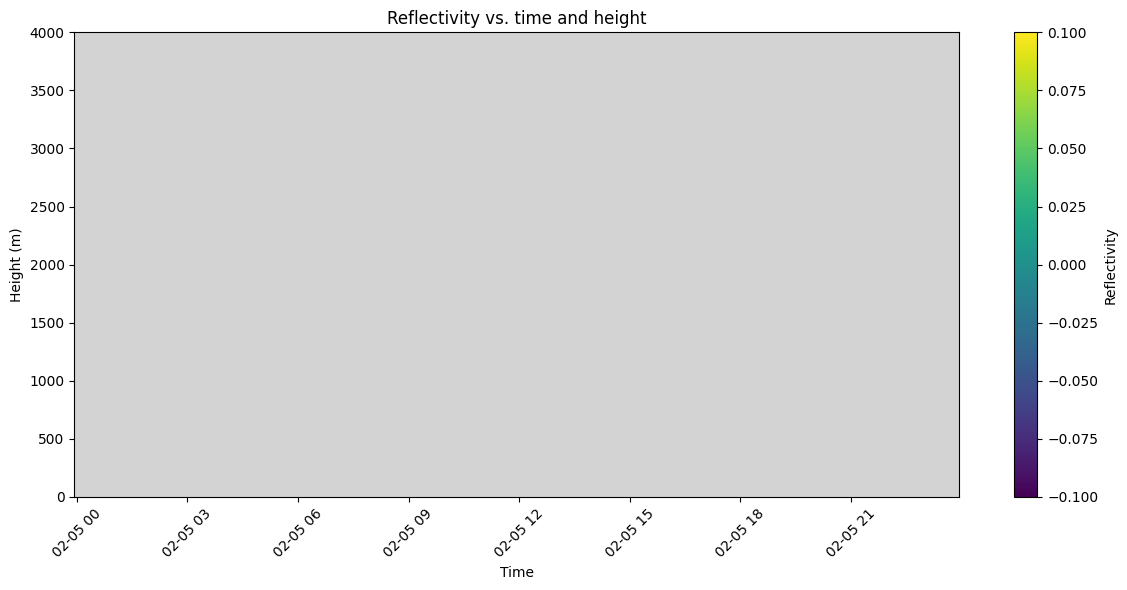

In [16]:
# Create a meshgrid for time and height to be used for all plots produced from the current file
time_mesh, height_mesh = np.meshgrid(UM_reg_emc2_marcus_MWACR_model.ds['time'], UM_reg_emc2_marcus_MWACR_model.ds['z0_hybrid_height'])

# Depol
# Extract the desired variable
reflectivity = UM_reg_emc2_marcus_MWACR_model.ds['sub_col_Ze_tot_strat'].isel(subcolumn=0).drop('subcolumn')
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, reflectivity.T, cmap = 'viridis', shading = 'auto')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'Reflectivity')
plt.title('Reflectivity vs. time and height')
plt.ylim(0, 4000)
plt.xticks(rotation = 45)
plt.tight_layout()
UM_reg_emc2_output_reflectivity = plt.gcf()
# Save the plot
# UM_reg_emc2_output_depol.savefig(f'/g/data/jk72/ck4840/projects/emc2/figs/um_reg/emc2_test/UM_reg_emc2_output_depol_{current_date_str}', dpi = 200)

In [ ]:
# # Create a meshgrid for time and height to be used for all plots produced from the current file
# time_mesh, height_mesh = np.meshgrid(emc2_output_test['time'], emc2_output_test['z0_hybrid_height'])

# # Backscatter
# # Extract the desired variable
# backscatter = emc2_output_test['sub_col_beta_p_tot_strat'].isel(subcolumn=0).drop('subcolumn')
# # Create the plot with a grey background
# plt.figure(figsize = (12, 6))
# plt.gca().set_facecolor('lightgrey')
# # Create and organise a pcolormesh plot
# pcm = plt.pcolormesh(time_mesh, height_mesh, backscatter.T, cmap = 'viridis', shading = 'auto', norm = LogNorm())
# plt.xlabel('Time')
# plt.ylabel('Height (m)')
# plt.colorbar(pcm, label = 'Backscatter (1/m*sr)')
# plt.title('Backscatter vs. time and height')
# plt.ylim(0, 4000)
# plt.xticks(rotation = 45)
# plt.tight_layout()
# UM_reg_emc2_output_backscatter = plt.gcf()
# # Save the plot
# UM_reg_emc2_output_backscatter.savefig(f'/g/data/jk72/ck4840/projects/emc2/figs/um_reg/emc2_test/UM_reg_emc2_output_backscatter_{current_date_str}', dpi = 200)

# Saved file plotting

In [19]:
# Load data

# Create the list of full filepaths to the daily files
# Set file parent folder
emc2_output_filepath = '/g/data/jk72/ck4840/projects/emc2/data/um_reg/emc2_output'
# List daily files in the parent folder
emc2_output_list = os.listdir(path = emc2_output_filepath)
# Create the list of daily filepaths
emc2_output_list = [os.path.join(emc2_output_filepath, file) for file in emc2_output_list]
# Sort the list by date
def extract_date(filepath):
    return filepath[12:-3]
emc2_output_list = sorted(emc2_output_list, key = extract_date)
emc2_output_list_MPL = [path for path in emc2_output_list if 'um_reg_emc2_marcus_MPL' in path]
emc2_output_list_MWACR = [path for path in emc2_output_list if 'um_reg_emc2_marcus_MWACR' in path]
# emc2_output_list_MPL
# emc2_output_list_MWACR

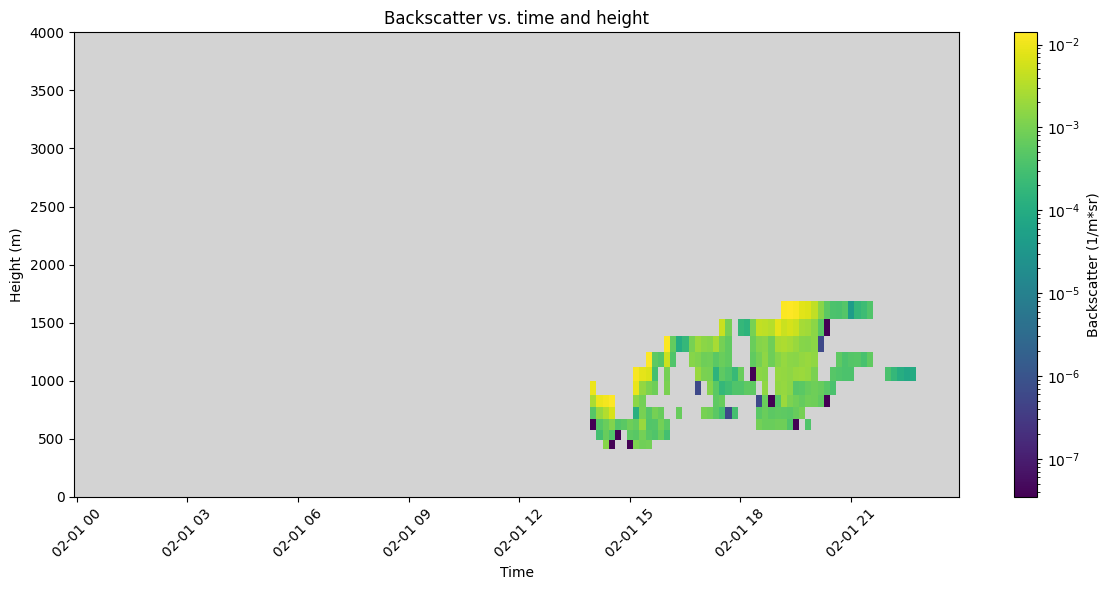

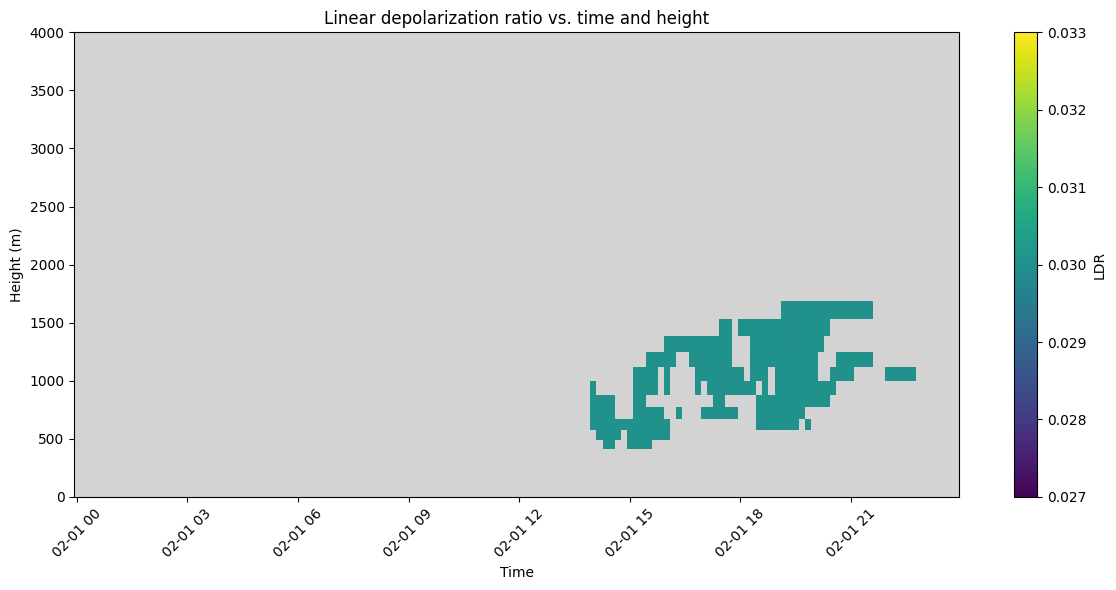

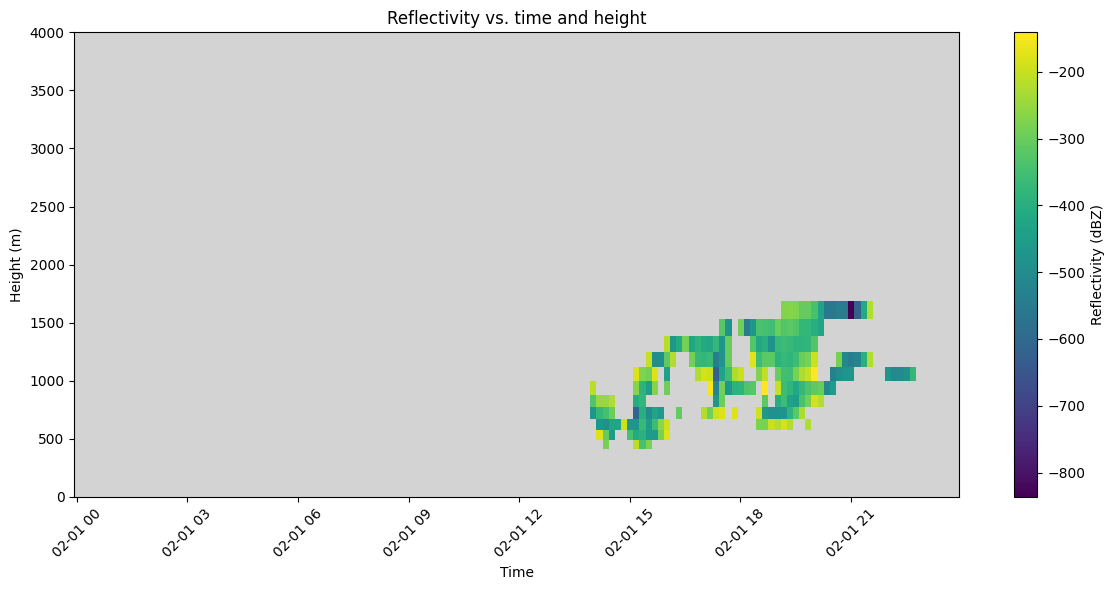

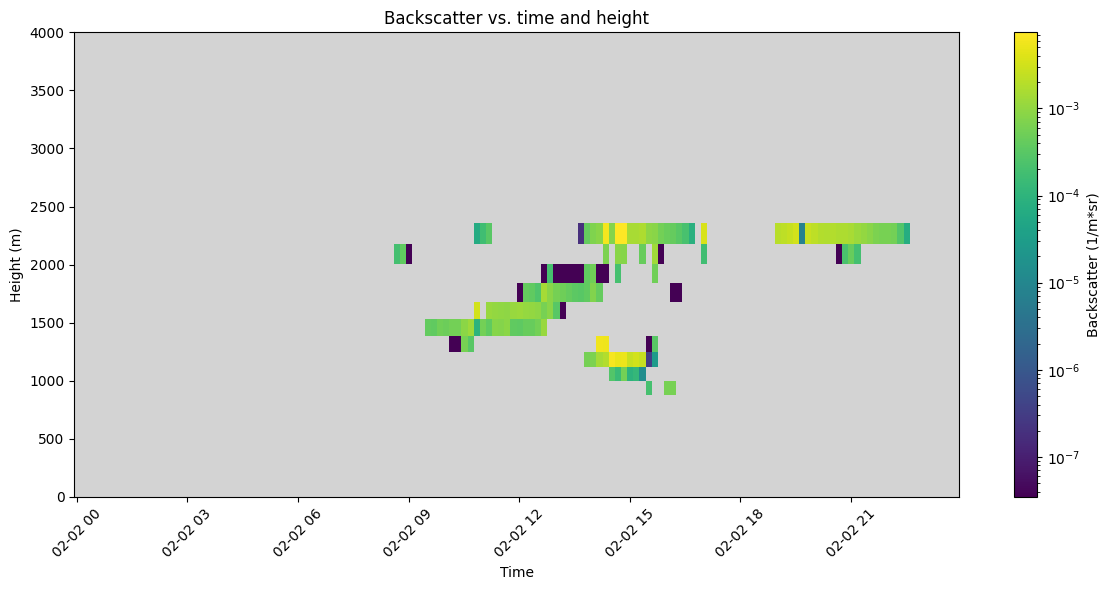

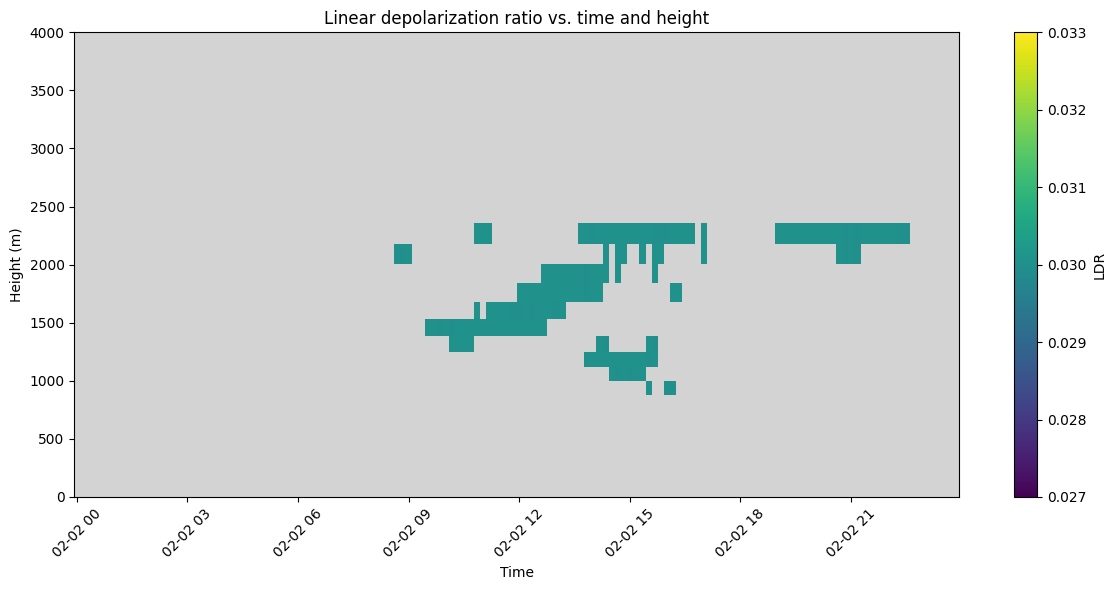

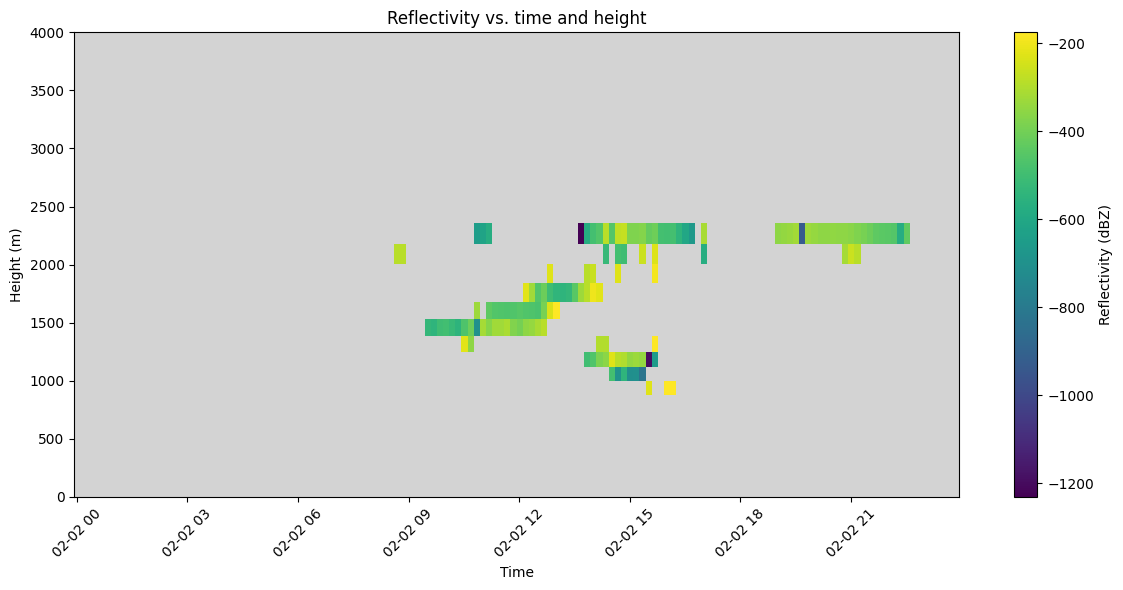

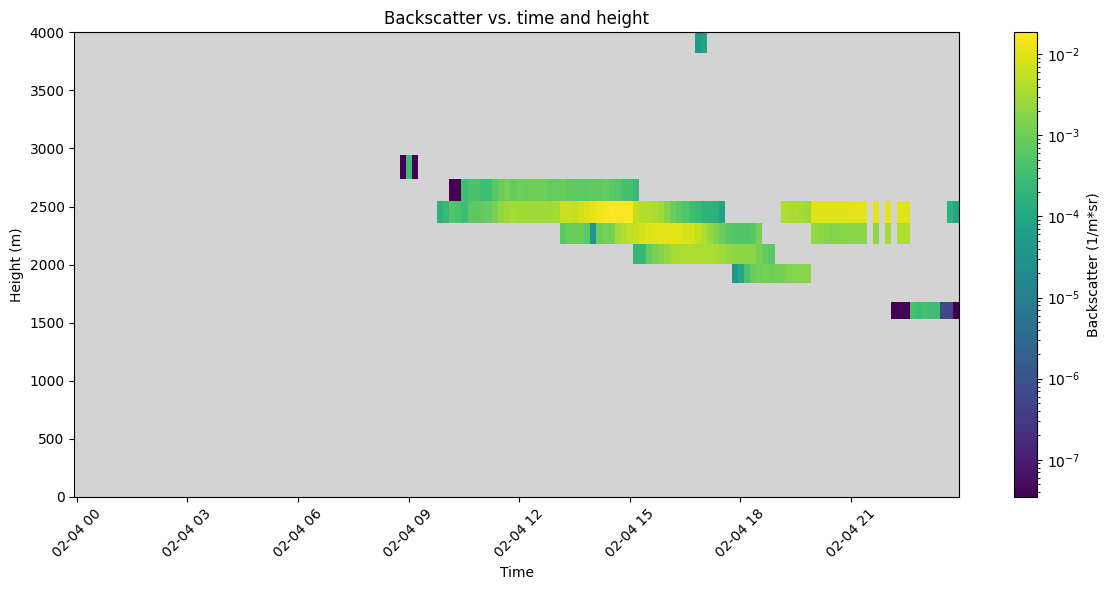

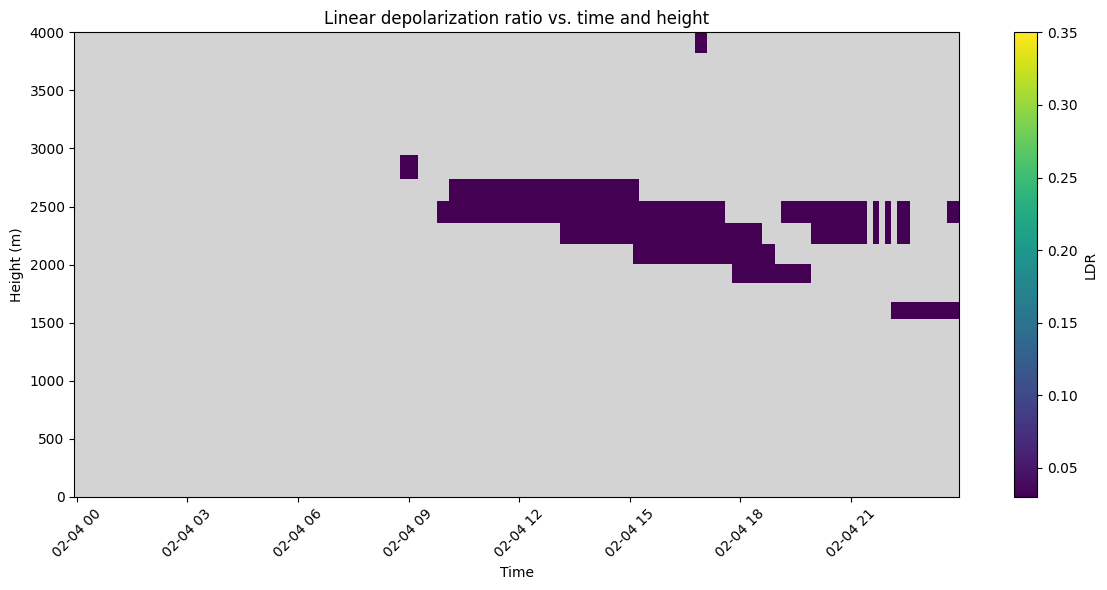

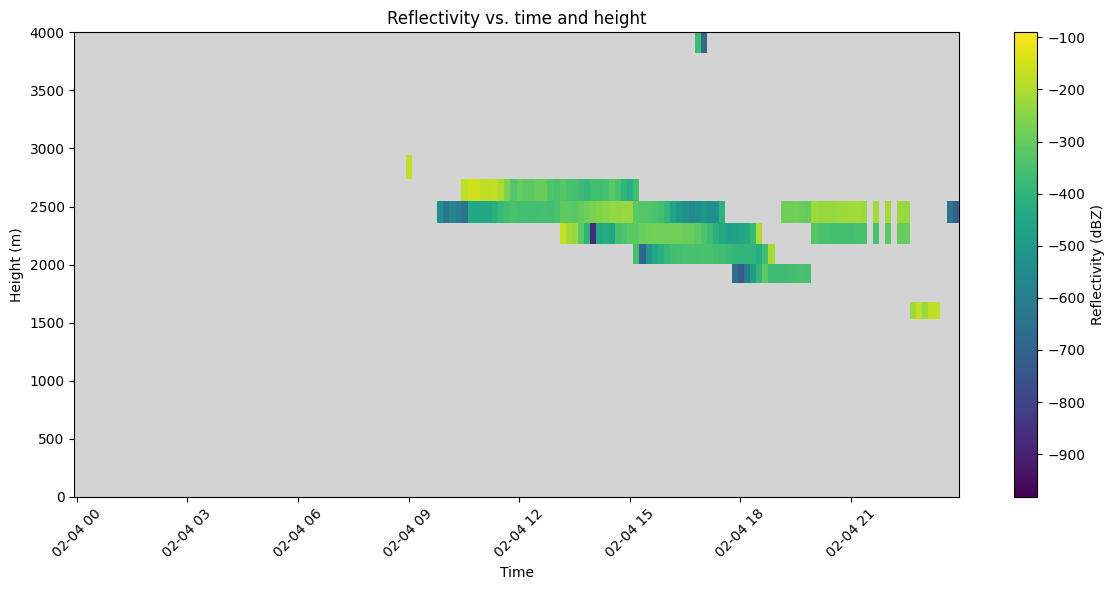

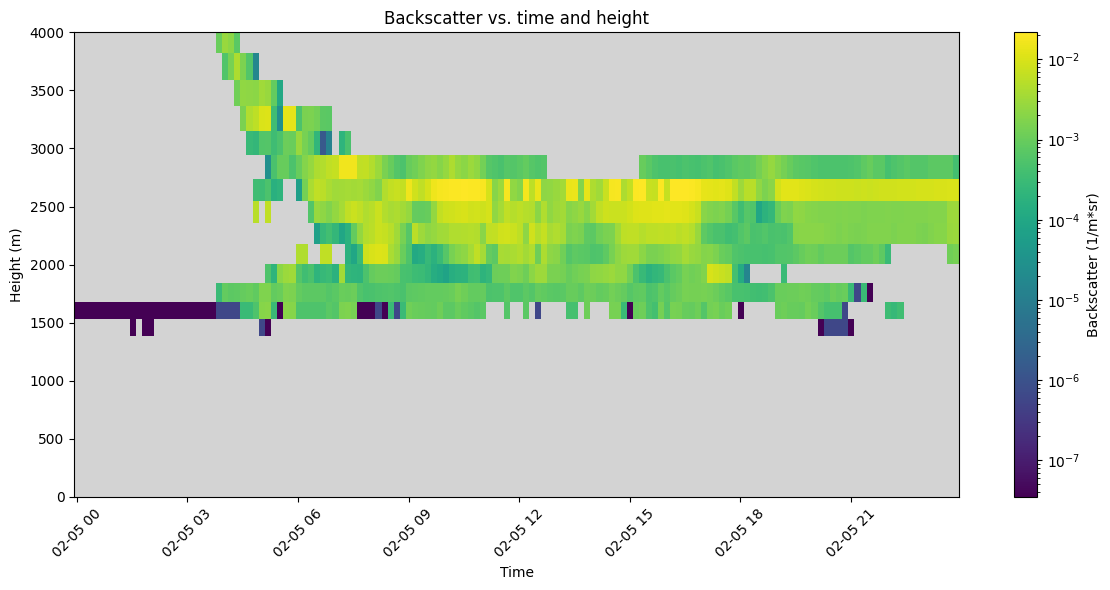

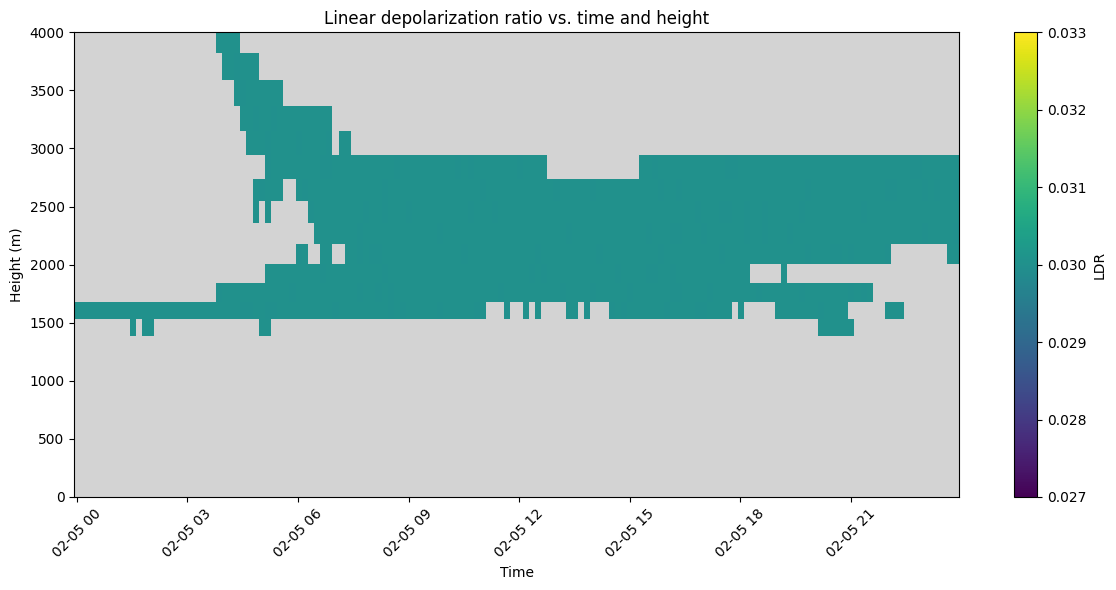

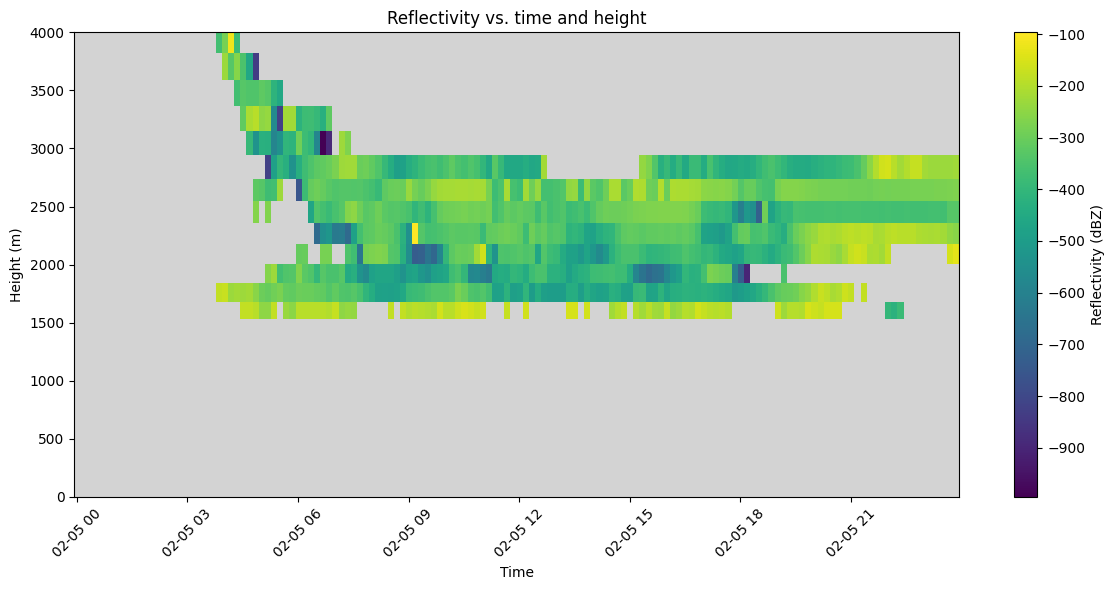

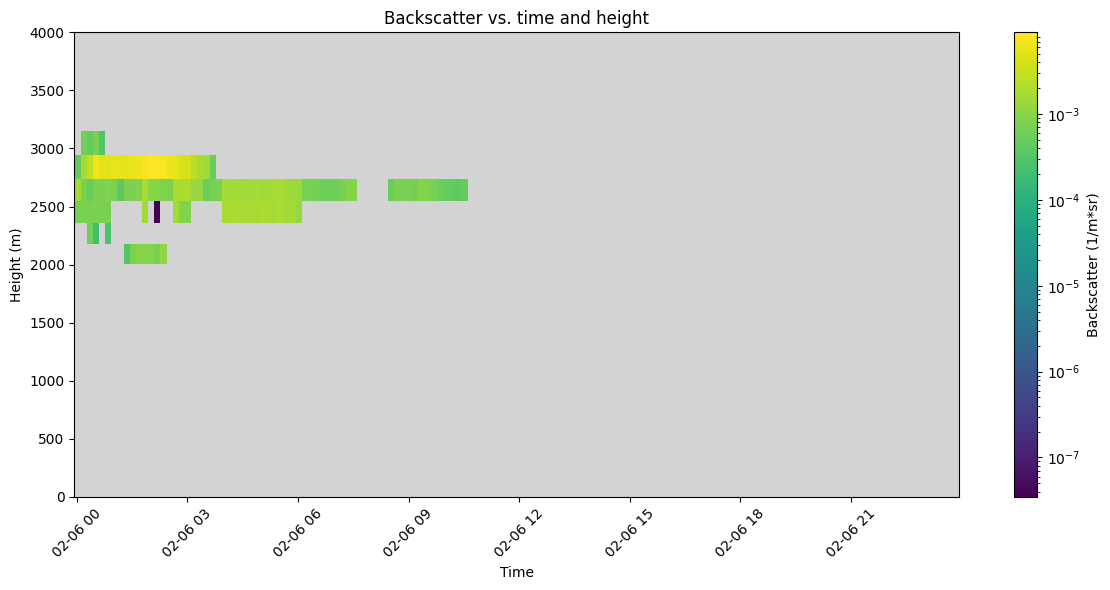

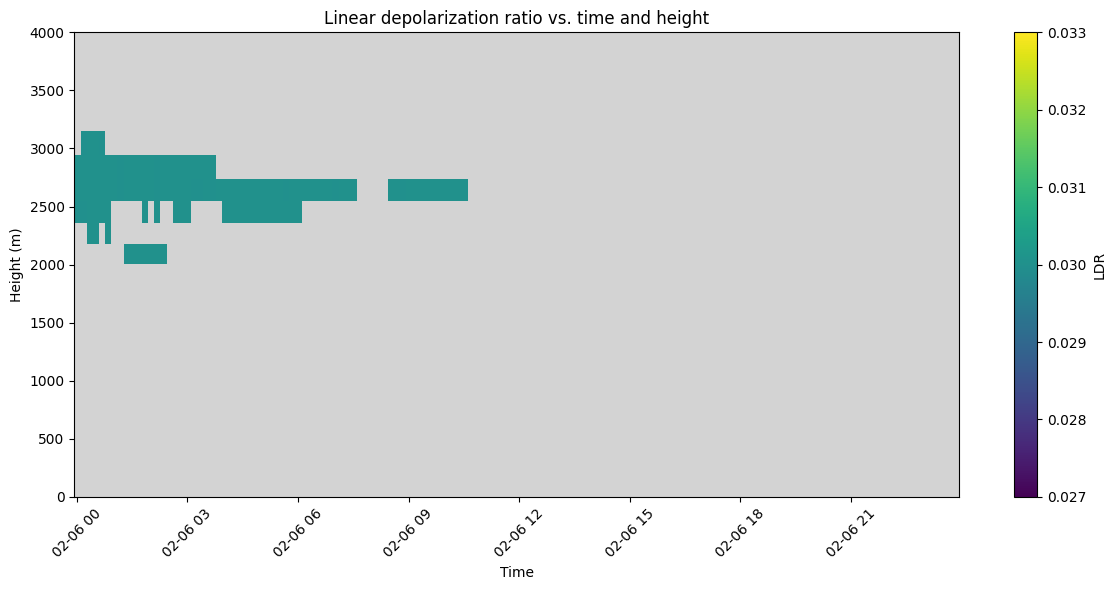

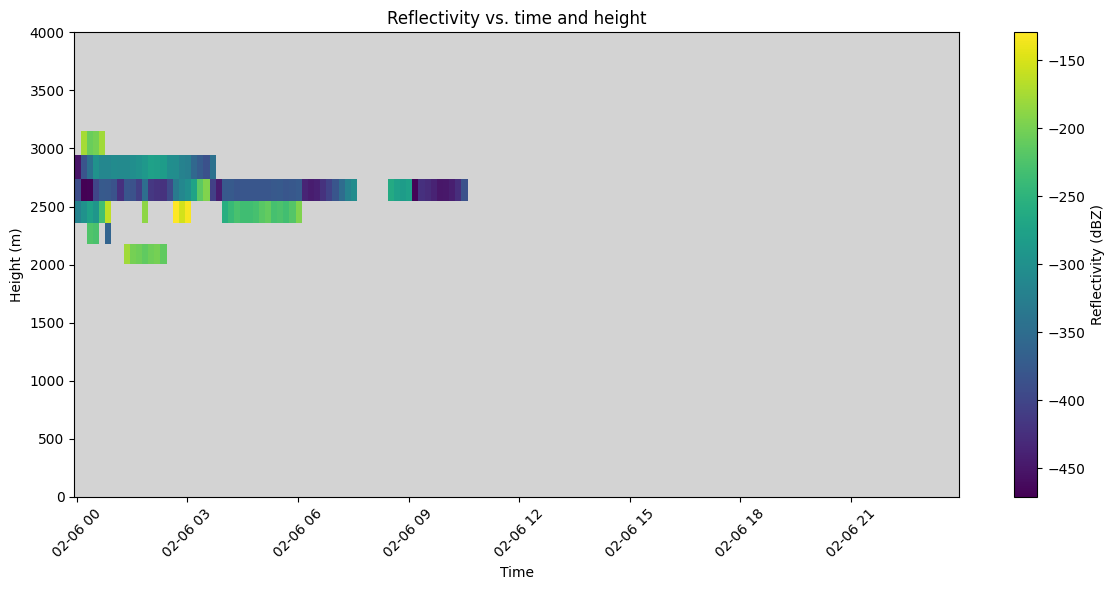

In [20]:
# Iterate across all files to create and save images of backscatter, depolarization, and reflectivity
for i in range(0, 6):
    # Skip day 3
    if i == 2:
        continue
    # Open files and extract current date
    file_MPL = emc2_output_list_MPL[i]
    file_MWACR = emc2_output_list_MWACR[i]
    emc2_output_test_MPL = xr.open_dataset(file_MPL)
    emc2_output_test_MWACR = xr.open_dataset(file_MWACR)
    current_date_str = file_MPL.split('_')[-1].split('.')[0]

    # Create a meshgrid for time and height to be used for all plots produced from the current file
    time_mesh, height_mesh = np.meshgrid(emc2_output_test_MPL['time'], emc2_output_test_MPL['z0_hybrid_height'])
    
    # Backscatter
    # Extract the desired variable
    backscatter = emc2_output_test_MPL['sub_col_beta_p_tot_strat'].isel(subcolumn=0).drop('subcolumn')
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, backscatter.T, cmap = 'viridis', shading = 'auto', norm = LogNorm())
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'Backscatter (1/m*sr)')
    plt.title('Backscatter vs. time and height')
    plt.ylim(0, 4000)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    UM_reg_emc2_output_backscatter = plt.gcf()
    # Save the plot
    UM_reg_emc2_output_backscatter.savefig(f'/g/data/jk72/ck4840/projects/emc2/figs/um_reg/emc2_test/UM_reg_emc2_output_backscatter_{current_date_str}', dpi = 200)

    # Create a meshgrid for time and height to be used for all plots produced from the current file
    time_mesh, height_mesh = np.meshgrid(emc2_output_test_MPL['time'], emc2_output_test_MPL['z0_hybrid_height'])
    
    # Depol
    # Extract the desired variable
    depol = emc2_output_test_MPL['sub_col_LDR_strat'].isel(subcolumn=0).drop('subcolumn')
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, depol.T, cmap = 'viridis', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'LDR')
    plt.title('Linear depolarization ratio vs. time and height')
    plt.ylim(0, 4000)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    UM_reg_emc2_output_depol = plt.gcf()
    # Save the plot
    UM_reg_emc2_output_depol.savefig(f'/g/data/jk72/ck4840/projects/emc2/figs/um_reg/emc2_test/UM_reg_emc2_output_depol_{current_date_str}', dpi = 200)

    # Create a meshgrid for time and height to be used for all plots produced from the current file
    time_mesh, height_mesh = np.meshgrid(emc2_output_test_MWACR['time'], emc2_output_test_MWACR['z0_hybrid_height'])
    
    # Reflectivity
    # Extract the desired variable
    reflectivity = emc2_output_test_MWACR['sub_col_Ze_tot_strat'].isel(subcolumn=0).drop('subcolumn')
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, reflectivity.T, cmap = 'viridis', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'Reflectivity (dBZ)')
    plt.title('Reflectivity vs. time and height')
    plt.ylim(0, 4000)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    UM_reg_emc2_output_reflectivity = plt.gcf()
    # Save the plot
    UM_reg_emc2_output_reflectivity.savefig(f'/g/data/jk72/ck4840/projects/emc2/figs/um_reg/emc2_test/UM_reg_emc2_output_reflectivity_{current_date_str}', dpi = 200)

In [14]:
# Open files and extract current date
file_MPL = emc2_output_list_MPL[6]
file_MWACR = emc2_output_list_MWACR[6]
emc2_output_test_MPL = xr.open_dataset(file_MPL)
emc2_output_test_MWACR = xr.open_dataset(file_MWACR)
current_date_str = file_MPL.split('_')[-1].split('.')[0]
# backscatter = emc2_output_test_MPL['sub_col_beta_p_tot_strat'].values
# depol = emc2_output_test_MPL['sub_col_LDR_strat'].values
# reflectivity = emc2_output_test_MPL['sub_col_LDR_strat'].values

In [112]:
# model_display = emc2.plotting.SubcolumnDisplay(UM_reg_emc2_marcus_MPL_model, figsize=(20, 10))
# ax_mod, _ = model_display.plot_subcolumn_timeseries("sub_col_beta_p_tot_strat", 0, log_plot=True, y_range=(0, 4000.),
#                                                  pressure_coords=False, cmap="viridis", vmin = 1e-6, vmax = 1e-3)#, vmin=1e-6, vmax=1e-3)
# ax_mod.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# model_display.fig.savefig(f'/g/data/jk72/ck4840/projects/emc2/figs/um_reg/emc2_test/MPL_backscatter_simulated_{current_date_str}.png', dpi=200)

In [15]:
# emc2_output_test_MPL
emc2_output_test_MWACR

<xarray.Dataset>
Dimensions:                           (z0_hybrid_height: 90, time: 144,
                                       subcolumn: 1)
Coordinates:
  * z0_hybrid_height                  (z0_hybrid_height) float64 5.0 ... 4e+04
  * time                              (time) datetime64[ns] 2018-02-07T00:01:...
  * subcolumn                         (subcolumn) int64 0
Data variables: (12/61)
    hus                               (time, z0_hybrid_height) float32 ...
    field12                           (time, z0_hybrid_height) float32 ...
    field75                           (time, z0_hybrid_height) float32 ...
    field76                           (time, z0_hybrid_height) float32 ...
    field78                           (time, z0_hybrid_height) float32 ...
    field79                           (time, z0_hybrid_height) float32 ...
    ...                                ...
    sub_col_Ze_att_tot_strat          (subcolumn, time, z0_hybrid_height) float64 ...
    Ze_min                            (time, z0_hybrid_height) float64 ...
    sub_col_Ze_tot                    (subcolumn, time, z0_hybrid_height) float64 ...
    sub_col_Ze_att_tot                (subcolumn, time, z0_hybrid_height) float64 ...
    detect_mask                       (time, z0_hybrid_height, subcolumn) bool ...
    phase_mask_WACR_sounding_all_hyd  (subcolumn, time, z0_hybrid_height) float64 ...

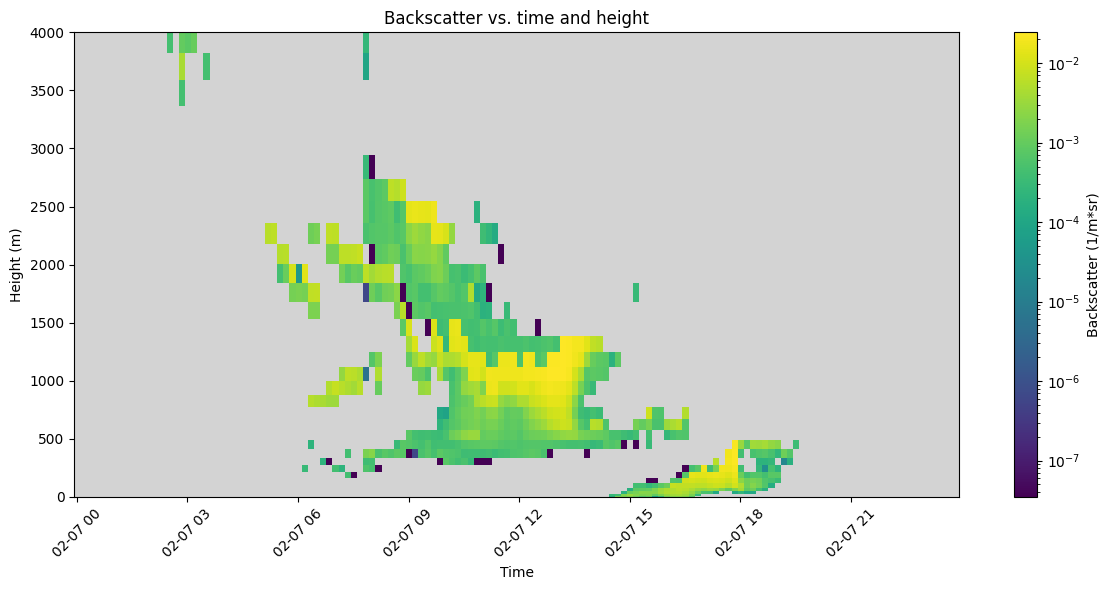

In [21]:
# Create a meshgrid for time and height to be used for all plots produced from the current file
time_mesh, height_mesh = np.meshgrid(emc2_output_test_MPL['time'], emc2_output_test_MPL['z0_hybrid_height'])

# Backscatter
# Extract the desired variable
backscatter = emc2_output_test_MPL['sub_col_beta_p_tot_strat'].isel(subcolumn=0).drop('subcolumn')
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, backscatter.T, cmap = 'viridis', shading = 'auto', norm = LogNorm())
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'Backscatter (1/m*sr)')
plt.title('Backscatter vs. time and height')
plt.ylim(0, 4000)
plt.xticks(rotation = 45)
plt.tight_layout()
UM_reg_emc2_output_backscatter = plt.gcf()
# Save the plot
UM_reg_emc2_output_backscatter.savefig(f'/g/data/jk72/ck4840/projects/emc2/figs/um_reg/emc2_test/UM_reg_emc2_output_backscatter_{current_date_str}', dpi = 200)

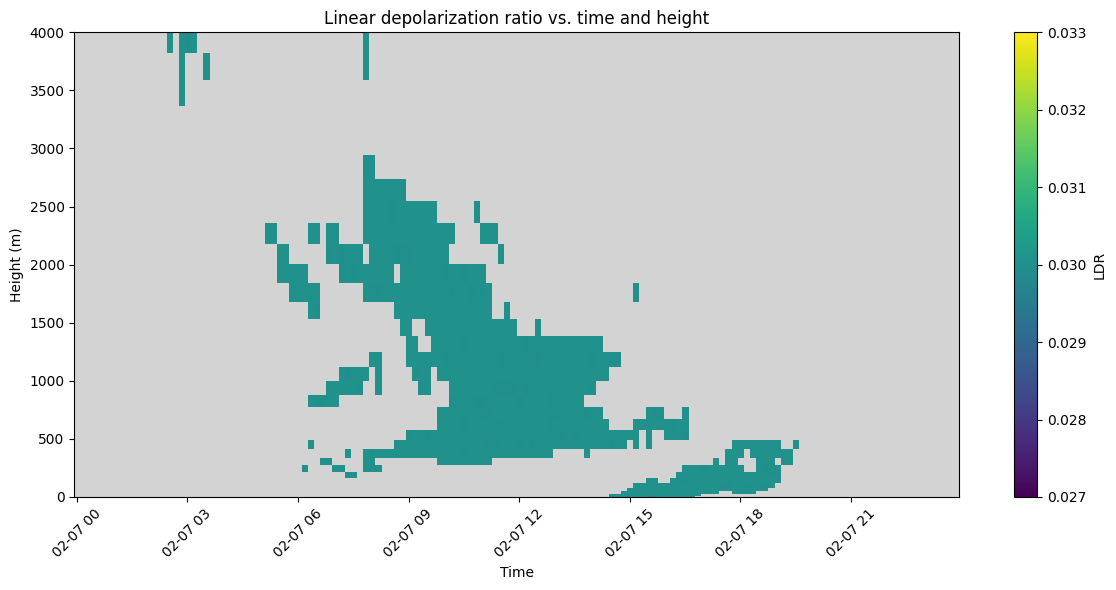

In [23]:
# Create a meshgrid for time and height to be used for all plots produced from the current file
time_mesh, height_mesh = np.meshgrid(emc2_output_test_MPL['time'], emc2_output_test_MPL['z0_hybrid_height'])

# Depol
# Extract the desired variable
depol = emc2_output_test_MPL['sub_col_LDR_strat'].isel(subcolumn=0).drop('subcolumn')
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, depol.T, cmap = 'viridis', shading = 'auto')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'LDR')
plt.title('Linear depolarization ratio vs. time and height')
plt.ylim(0, 4000)
plt.xticks(rotation = 45)
plt.tight_layout()
UM_reg_emc2_output_depol = plt.gcf()
# Save the plot
UM_reg_emc2_output_depol.savefig(f'/g/data/jk72/ck4840/projects/emc2/figs/um_reg/emc2_test/UM_reg_emc2_output_depol_{current_date_str}', dpi = 200)

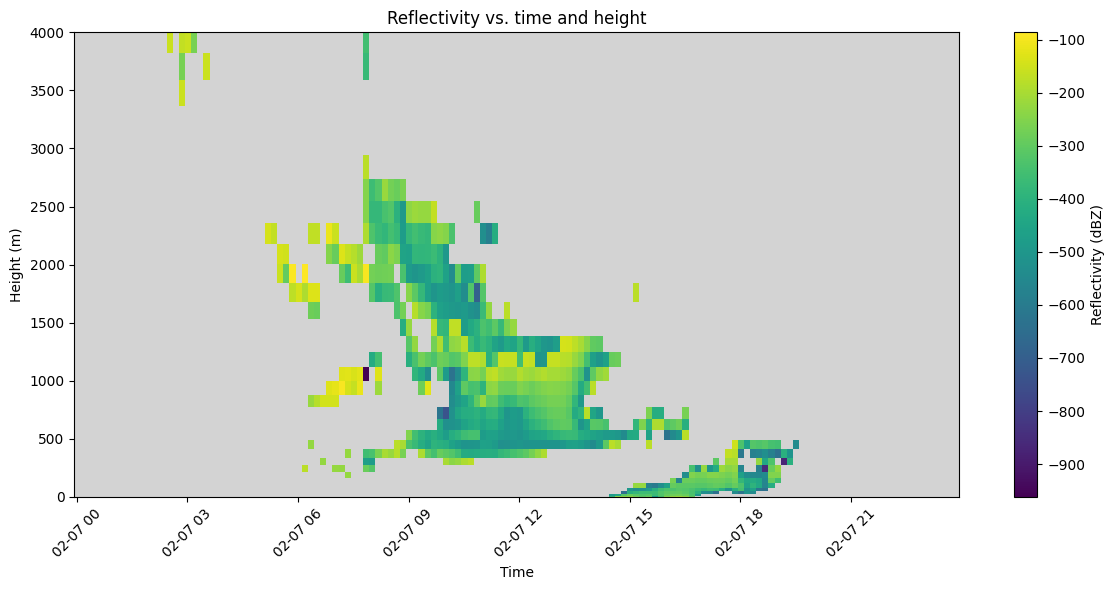

In [25]:
# Create a meshgrid for time and height to be used for all plots produced from the current file
time_mesh, height_mesh = np.meshgrid(emc2_output_test_MWACR['time'], emc2_output_test_MWACR['z0_hybrid_height'])

# Reflectivity
# Extract the desired variable
reflectivity = emc2_output_test_MWACR['sub_col_Ze_tot_strat'].isel(subcolumn=0).drop('subcolumn')
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, reflectivity.T, cmap = 'viridis', shading = 'auto')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'Reflectivity (dBZ)')
plt.title('Reflectivity vs. time and height')
plt.ylim(0, 4000)
plt.xticks(rotation = 45)
plt.tight_layout()
UM_reg_emc2_output_reflectivity = plt.gcf()
# Save the plot
UM_reg_emc2_output_reflectivity.savefig(f'/g/data/jk72/ck4840/projects/emc2/figs/um_reg/emc2_test/UM_reg_emc2_output_reflectivity_{current_date_str}', dpi = 200)